In [446]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2
from typing import Any
from numpy import dtype, floating, ndarray
from numpy._typing import _64Bit

## Forward Scattering

In [447]:
def circle_data(a: float, N: int)  -> ndarray[Any, dtype[floating[_64Bit]]]:
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    # xn yn xn+1 yn+1 ln phi_n nx ny
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        xn = a * np.cos((2 * np.pi / N) * (i))
        yn = a * np.sin((2 * np.pi / N) * (i))
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    # Calculate ln, phi_n, nx, ny
    ln = np.sqrt((data[:, 2] - data[:, 0])**2 + (data[:, 3] - data[:, 1])**2)
    phi_n = np.arctan2(data[:, 3] - data[:, 1], data[:, 2] - data[:, 0])
    nx = (data[:, 3] - data[:, 1]) / ln
    ny = -(data[:, 2] - data[:, 0]) / ln
    # Concatenate calculated values to data array
    data = np.column_stack((data, ln, phi_n, nx, ny))    
    return data

def circle_data_aux(a: float, N: int)  -> ndarray[Any, dtype[floating[_64Bit]]]:
    """
    Calculate coordinates, lengths, angles, and normals for points on a circle.

    Args:
        a (float): Radius of the circle.
        N (int): Number of points to generate.

    Returns:
        numpy.ndarray: Array containing coordinates (x, y), lengths, angles,
                       and normals for each point.
    """
    # xn yn xn+1 yn+1 ln phi_n nx ny
    data = np.zeros((N, 2))
    # Calculate coordinates xn, yn
    for i in range(N):
        xn = a * np.cos((2 * np.pi / N) * (i))
        yn = a * np.sin((2 * np.pi / N) * (i))
        data[i, 0] = xn
        data[i, 1] = yn
    # Duplicate first row at the end for circularity
    circular_data = np.vstack((data[1:], data[0]))
    data = np.hstack((data, circular_data))
    # Calculate ln, phi_n, nx, ny
    ln = np.sqrt((data[:, 2] - data[:, 0])**2 + (data[:, 3] - data[:, 1])**2)
    phi_n = np.arctan2(data[:, 3] - data[:, 1], data[:, 2] - data[:, 0])
    nx = (data[:, 3] - data[:, 1]) / ln
    ny = -(data[:, 2] - data[:, 0]) / ln
    # Concatenate calculated values to data array
    data = np.column_stack((data, ln, phi_n, nx, ny))    
    return data


In [448]:
def calculate_current_distribution_aux_sources(data_contour: np.ndarray, data_aux: np.ndarray, phi_i: float) -> np.ndarray:
    """
    Calculate the current distribution for auxiliary sources.

    Args:
        data_contour: Contour data.
        data_aux: Auxiliary sources data.
        phi_i: Angle of incidence in degrees.

    Returns:
        ndarray: Current distribution for auxiliary sources.
    """
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    M = len(data_contour)  # Number of segments
    N = len(data_aux)  # Number of auxiliary sources
    Z = np.zeros((M, N), dtype=complex)  # Impedance matrix
    V = np.zeros((M, 1), dtype=complex)  # Excitation vector
    
    # Calculate impedance matrix
    for l in range(N):
        xm, ym = data_aux[l, 0], data_aux[l, 1]
        for m in range(M):
            xl, yl = data_contour[m, 0], data_contour[m, 1]
            rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
            Z[m, l] += hankel2(0, k * rml)

    # Calculate excitation vector
    for i in range(M):
        xm = data_contour[i, 0]
        ym = data_contour[i, 1]
        V[i] = np.exp(1j * k * (xm * np.cos(phi_i) + ym * np.sin(phi_i)))
    
    # Solve the least squares problem
    I, residuals, _, _ = np.linalg.lstsq(Z, -V, rcond=0.01)
    
    return I

In [449]:
def scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i] += hankel2(0, k * r) * I[j,0]
    return e_scat

def incident_field(xn_grid: np.ndarray, yn_grid: np.ndarray, phi_inc: float) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the incident field at observation points.

    Args:
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.
        phi_inc: Angle of incidence.

    Returns:
        ndarray: Incident field at observation points.
    """
    k = 2 * np.pi 
    N = len(xn_grid)
    phi_inc = np.deg2rad(phi_inc)  # Angle of incidence in radians
    e_inc = np.zeros((N, N), dtype=complex)  # Initialize incident field vector
    
    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        e_inc[i] = np.exp(1j * k * (xn * np.cos(phi_inc) + yn * np.sin(phi_inc)))
    return e_inc   

def scattered_field_obs(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculate the scattered field at observation points.

    Args:
        data: Auxiliary sources data.
        I: Current distribution.
        xn_grid: x-coordinates of observation points.
        yn_grid: y-coordinates of observation points.

    Returns:
        ndarray: Scattered field at observation points.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(xn_grid)
    M = len(data)
    e_scat = np.zeros((N,1), dtype=complex)  # Initialize scattered field vector

    for i in range(N):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(M):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_scat[i,0] += hankel2(0, k * r) * I[j,0]
    return e_scat


In [450]:
# Plot the current distribution on the contour
a_contour = 3
a_aux = a_contour - 0.1
M = 50*int(2*np.pi*a_contour)
N = 30*int(2*np.pi*a_aux)

print("Number of matching points: ", M)
print("Number of auxiliary sources: ", N)

data_contour = circle_data(a_contour, M)
data_aux = circle_data_aux(a_aux, N)
phi_i = 0   # Angle of incidence in degrees
I = calculate_current_distribution_aux_sources(data_contour, data_aux, phi_i)

grid_size = 1000  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

# Calculate distance of each grid point from the center of the circle
distance_to_center = np.sqrt((x_grid)**2 + (y_grid)**2)

# Remove points within the circular region
mask = distance_to_center < a_contour
x_grid[mask] = np.nan
y_grid[mask] = np.nan

e_scat_aux = scattered_field(data_aux, I, x_grid, y_grid)
e_inc = incident_field(x_grid, y_grid, phi_i)
e_total = e_inc + e_scat_aux



Number of matching points:  900
Number of auxiliary sources:  540


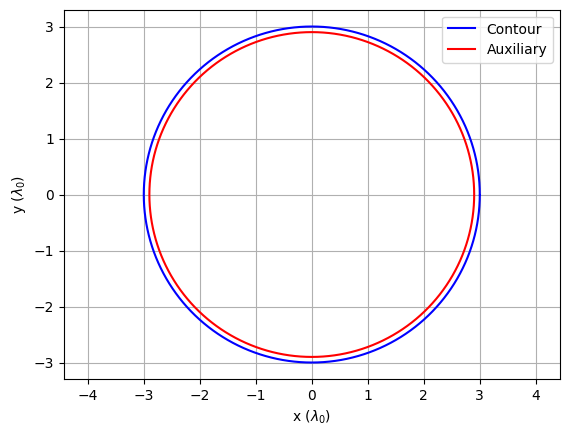

In [451]:
fig, ax = plt.subplots()
ax.plot(data_contour[:, 0], data_contour[:, 1], 'b')
ax.plot(data_aux[:, 0], data_aux[:, 1], 'r')
ax.axis('equal')
plt.xlabel(r'x $(\lambda_{0})$')
plt.ylabel(r'y $(\lambda_{0})$')
plt.legend(['Contour', 'Auxiliary'])    
plt.grid()
plt.show()

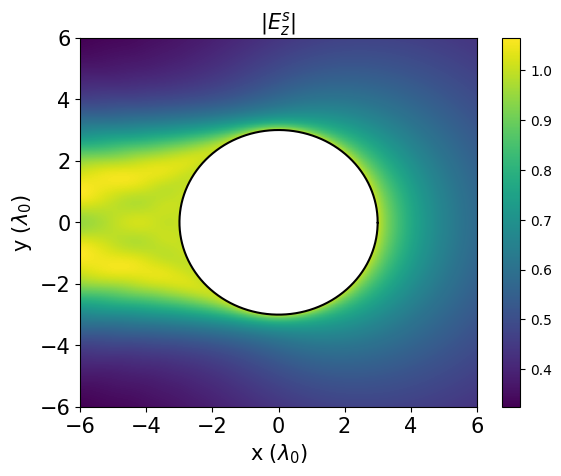

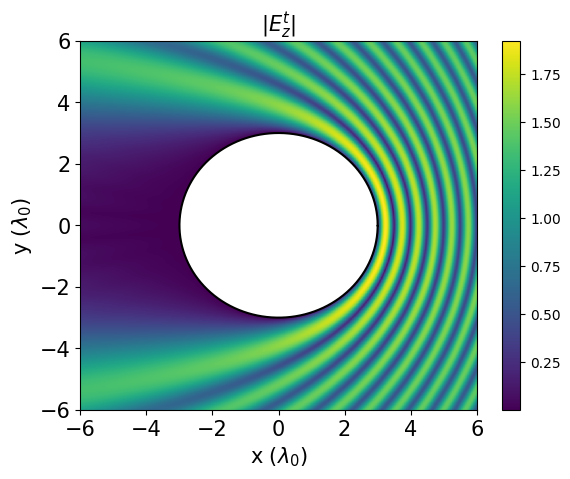

In [452]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_scat_aux), shading='auto')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_total), shading='auto')
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.plot(data_contour[:, 0], data_contour[:, 1], color='black')  # Plot contour of the scatterer
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Inverse scattering

In [459]:
a_obs = 8
a_aux = 2
M = 30*int(2*np.pi*a_aux)
N = 10*int(2*np.pi*a_obs)
J = 1
data_obs = circle_data(a_obs, N)
data_aux = circle_data_aux(a_aux, M)
x_obs = data_obs[:, 0]
y_obs = data_obs[:, 1]

phi_i = np.linspace(0, 360, J)
scattered_fields = np.zeros((N, J), dtype=complex)

for j in range(J):
    I = calculate_current_distribution_aux_sources(data_contour, data_aux, phi_i[j])
    e_scat = scattered_field_obs(data_aux, I, x_obs, y_obs)
    scattered_fields[:, j] = e_scat[:, 0]

print("Number of auxiliary sources: ", M)
print("Number of observation points: ", N)


Number of auxiliary sources:  360
Number of observation points:  500


In [463]:
def cv_inverse_scattering(data_obs: np.ndarray, data_aux: np.ndarray, J: int, scattered_field: np.ndarray, phi_i: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Computes the coefficient vector (cv) for inverse scattering.

    Args:
        data_obs (ndarray): Array containing coordinates of observable points.
        data_aux (ndarray): Array containing coordinates of auxiliary sources.
        J (int): Number of iterations.
        scattered_field (ndarray): Scattered field.
        phi_i (ndarray): Angle of incidence in radians.

    Returns:
        ndarray: Coefficient vector.
    """
    M = len(data_obs)  # Number of observable points
    N = len(data_aux)  # Number of auxiliary sources
    k = 2 * np.pi  # Wavenumber
    phi_i = np.deg2rad(phi_i)  # Angle of incidence in radians
    Z = np.zeros((M, N), dtype=complex)
    cv = np.zeros((N, J), dtype=complex)

    print("Matrix shape of Z: ",Z.shape)
    print("Matrix shape of the scattered field: ", scattered_field.shape)
    print("Matrix shape of the cv: ", cv.shape)
    for j in range(J):
        for l in range(N):
            xm = data_aux[l, 0]
            ym = data_aux[l, 1]
            for m in range(M):
                xl = data_obs[m, 0]
                yl = data_obs[m, 1]
                rml = np.sqrt((xm - xl)**2 + (ym - yl)**2)
                Z[m,l] += hankel2(0, k * rml)
        # Solve the regularized least squares problem
        cv[:,j], residuals, _, _ = np.linalg.lstsq(Z, scattered_field[:,j], rcond=0.01)

    return cv

In [464]:
def inverse_scattered_field(data: np.ndarray, I: np.ndarray, xn_grid: np.ndarray, yn_grid: np.ndarray) -> ndarray[Any, dtype[Any]]:
    """
    Calculates the inverse scattered field.

    Args:
        data (ndarray): Array containing coordinates of points on the contour.
        I (ndarray): Incident field vector.
        xn_grid (ndarray): x-coordinates grid.
        yn_grid (ndarray): y-coordinates grid.

    Returns:
        ndarray: Inverse scattered field vector.
    """
    k = 2 * np.pi  # Wavenumber
    N = len(data)
    M = len(xn_grid)
    e_inv_scat = np.zeros((M, M), dtype=complex)  # Initialize scattered field vector
    for i in range(M):
        xn = xn_grid[i]
        yn = yn_grid[i]
        for j in range(N):
            xm = data[j, 0]  # x-coordinate of the point on the contour
            ym = data[j, 1]  # y-coordinate of the point on the contour
            r = np.sqrt((xn - xm)**2 + (yn - ym)**2)
            e_inv_scat[i] += hankel2(0, k * r) * I[j]
    return e_inv_scat

In [465]:
N = 1000
grid_size = N  # Size of the grid
x_min, x_max = -6, 6  # X-coordinate range
y_min, y_max = -6, 6  # Y-coordinate range


x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))

cv = cv_inverse_scattering(data_obs, data_aux, J, scattered_fields, phi_i)
e_inv_scat = np.zeros((N, N), dtype=complex)
for j in range(J):
    e_inv_scat += inverse_scattered_field(data_aux, cv[:,j], x_grid, y_grid)


e_inv_inc = np.zeros((N, N), dtype=complex)
for j in range(J):
    e_inv_inc += incident_field(x_grid, y_grid, phi_i[j])
    
e_inv_total = e_inv_inc + e_inv_scat


Matrix shape of Z:  (500, 360)
Matrix shape of the scattered field:  (500, 1)
Matrix shape of the cv:  (360, 1)


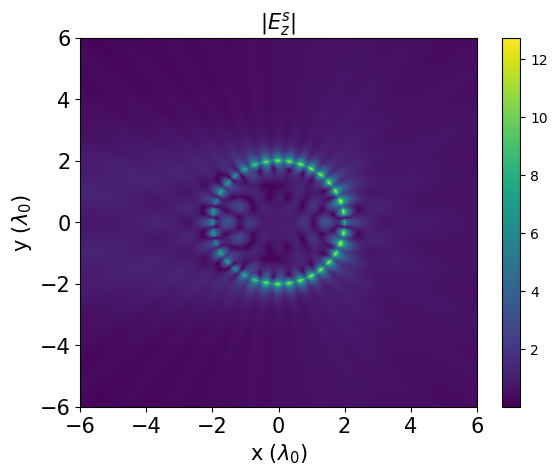

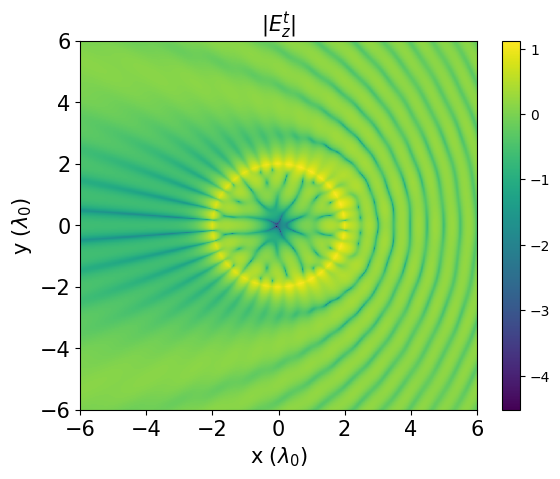

In [466]:
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                              np.linspace(y_min, y_max, grid_size))
plt.figure()
plt.pcolormesh(x_grid, y_grid, np.abs(e_inv_scat), shading='auto')
#plt.plot(data_contour[:, 0], data_contour[:, 1], color='white')
plt.title(r'|$E^{s}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.figure()
plt.pcolormesh(x_grid, y_grid, np.log10(np.abs(e_inv_total)), shading='auto')
#plt.plot(data_contour[:, 0], data_contour[:, 1], color='white') 
plt.title(r'|$E^{t}_{z}$|', fontsize=15)
plt.colorbar()
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

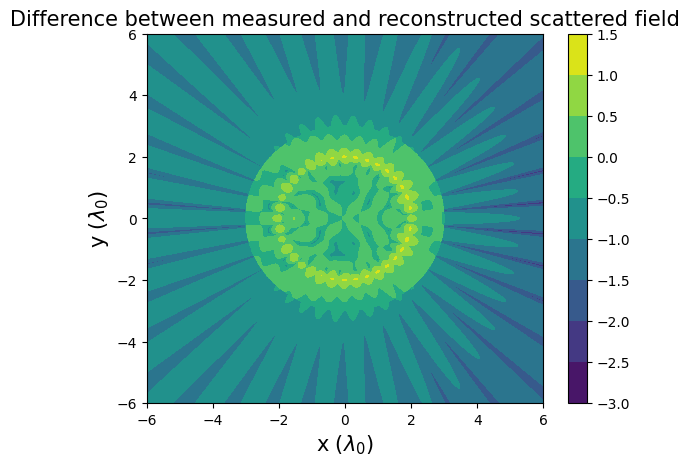

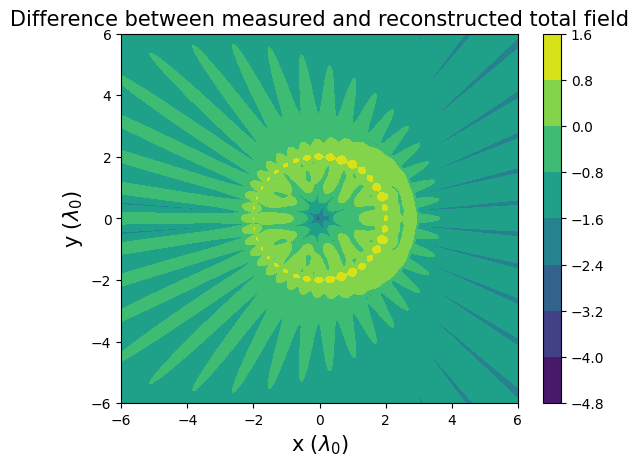

In [467]:
# Calculate the difference between e_scat_aux and e_inv_scat
diff_scat = e_scat_aux - e_inv_scat
diff_total = e_total - e_inv_total
nan_mask = np.isnan(e_scat_aux)
nan_mask = np.isnan(e_total)
diff_scat = np.where(nan_mask, e_inv_scat, diff_scat)
diff_total = np.where(nan_mask, e_inv_total, diff_total)

plt.figure()
plt.contourf(x_grid, y_grid, np.log10(np.abs(diff_scat)), cmap='viridis')
#plt.plot(data_contour[:, 0], data_contour[:, 1], color='white') 
plt.colorbar()
plt.title(r'Difference between measured and reconstructed scattered field', fontsize=15)
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.show()

plt.figure()
plt.contourf(x_grid, y_grid, np.log10(np.abs(diff_total)), cmap='viridis')
#plt.plot(data_contour[:, 0], data_contour[:, 1], color='white') 
plt.colorbar()
plt.title(r'Difference between measured and reconstructed total field', fontsize=15)
plt.xlabel(r'x $(\lambda_{0})$', fontsize=15)
plt.ylabel(r'y $(\lambda_{0})$', fontsize=15)
plt.show()